# Problem Statement
Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.passengers and crew.

# Identify-the-Sentiments
Provided with tweet data to predict sentiment on electronic products of netizens.

**Note :-** Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.

# Section 1: Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.notebook_repr_html', True)

In [2]:
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Section 2: Read Data

In [3]:
# reading dataset
train = pd.read_csv('train_2kmZucJ.csv')
test = pd.read_csv('test_oJQbWVk.csv')
# concatenating both datasets
df = pd.concat([train, test])
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [4]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [6]:
# checking for shape
print(train.shape, test.shape, df.shape)

(7920, 3) (1953, 2) (9873, 3)


In [7]:
df.describe()

,id,label
count,9873.000000,7920.000000
mean,4937.000000,0.255808
std,2850.233938,0.436342
min,1.000000,0.000000
25%,2469.000000,0.000000
50%,4937.000000,0.000000
75%,7405.000000,1.000000
max,9873.000000,1.000000


In [8]:
# checking dtypes
df.dtypes

id         int64
label    float64
tweet     object
dtype: object

In [9]:
df.isnull().sum()

id          0
label    1953
tweet       0
dtype: int64

# Section 3: EDA and Feature Generation

In [10]:
# Checking unique labels
df['label'].value_counts()

0.0    5894
1.0    2026
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

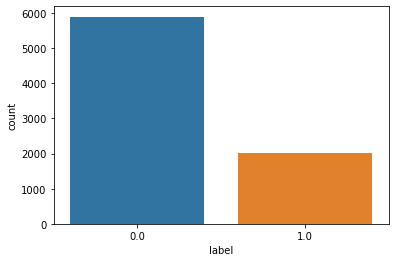

In [11]:
# Ploting unique labels
sns.countplot(x='label', data=df)

In [12]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
    
    #remove double spaces 
    text = re.sub('\s+', ' ',text)
    
    return text

df["clean_tweet"] = df.tweet.apply(lambda x: clean_text(x))

In [39]:
test["clean_tweet"] = test.tweet.apply(lambda x: clean_text(x))

In [13]:
#defining stop words
STOP_WORDS = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and',
              'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
              'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'com', 'could', "couldn't", 'did',
              "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'else', 'ever',
              'few', 'for', 'from', 'further', 'get', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
              'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how',
              "how's", 'however', 'http', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it',
              "it's", 'its', 'itself', 'just', 'k', "let's", 'like', 'me', 'more', 'most', "mustn't", 'my', 'myself',
              'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'otherwise', 'ought', 'our', 'ours',
              'ourselves', 'out', 'over', 'own', 'r', 'same', 'shall', "shan't", 'she', "she'd", "she'll", "she's",
              'should', "shouldn't", 'since', 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs',
              'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're",
              "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't",
              'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
              "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't",
              'www', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [14]:
# Remove stopwords from all the tweets
df['cleaned_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

In [40]:
# Remove stopwords from all the tweets
test['cleaned_tweet'] = test['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

In [15]:
#Adding New feature length of Tweet
df['word_count']=df.cleaned_tweet.str.split().apply(lambda x: len(x))

In [41]:
#Adding New feature length of Tweet
test['word_count']=test.cleaned_tweet.str.split().apply(lambda x: len(x))

In [16]:
#Adding New Feature Polarity Score
sid= SentimentIntensityAnalyzer()
sid.polarity_scores(df.iloc[0]['cleaned_tweet'])
df['scores'] =df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df['compound'] =df['scores'].apply(lambda d:d['compound'])
df['comp_score'] = df['compound'].apply(lambda score: '0' if score>=0 else '1')

In [42]:
#Adding New Feature Polarity Score
sid= SentimentIntensityAnalyzer()
sid.polarity_scores(df.iloc[0]['cleaned_tweet'])
test['scores'] =test['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
test['compound'] =test['scores'].apply(lambda d:d['compound'])
test['comp_score'] = test['compound'].apply(lambda score: '0' if score>=0 else '1')

In [17]:
# Remove unnecessary
ndf=df.copy()
ndf = ndf.drop(['tweet','clean_tweet','scores','compound','word_count','comp_score'], axis = 1) 

In [43]:
# Remove unnecessary
ndt=test.copy()
ndt = ndt.drop(['tweet','clean_tweet','scores','compound','word_count','comp_score'], axis = 1) 

In [18]:
ndf.head()

,id,label,cleaned_tweet
0,1,0.0,fingerprint pregnancy test android apps beauti...
1,2,0.0,finally transparant silicon case thanks uncle ...
2,3,0.0,love go talk makememories unplug relax iphone ...
3,4,0.0,wired know george made way iphone cute daventr...
4,5,1.0,amazing service apple even talk question unles...


In [45]:
ndt.head()

,id,cleaned_tweet
0,7921,hate new iphone upgrade let download apps ugh ...
1,7922,currently shitting fucking pants apple imac ca...
2,7923,puts cd roms ipad possible ' yes block screen
3,7924,ipod officially dead lost pictures videos d so...
4,7925,fighting itunes night want music paid


# Section 4: Model Building

In [19]:
# Seperating Train and Test Set
train_set = ndf[~ndf.label.isnull()]
test_set = ndf[ndf.label.isnull()]

In [20]:
# Shape
print(train_set.shape,test_set.shape)

(7920, 3) (1953, 3)


(1953, 2)

In [21]:
# Defining X and Y
X = train_set.drop(['label'], axis=1)
y = train_set.label
# Droping target columns
test_set = test_set.drop(['label'], axis=1)

In [22]:
X=X['cleaned_tweet'].astype(str)

In [23]:
#Train test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 3)

To perform further analysis we need to transform our data into a format that can be processed by our machine learning models.

- **CountVectorizer** does text preprocessing, tokenizing and filtering of stopwords and it builds a dictionary of features and transform documents to feature vectors.
- **TfidfTransformer** transforms the above vector by dividing the number of occurrences of each word in a document by the total number of words in the document. These new features are called tf for Term Frequencies.

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5544,) (2376,) (5544,) (2376,)


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [48]:
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer()
vect.fit(X_train)
test_dtm = vect.transform(test)

<5544x13203 sparse matrix of type '<class 'numpy.int64'>'
	with 60254 stored elements in Compressed Sparse Row format>

### Random Forest

In [26]:
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train_dtm,y_train)
rf = model.predict(X_test_dtm)
print("Accuracy:",accuracy_score(y_test,rf)*100,"%")

Accuracy: 86.9949494949495 %


Normalized confusion matrix
[[0.95 0.05]
 [0.36 0.64]]


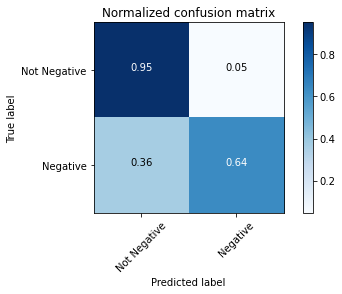

              precision    recall  f1-score   support

Not Negative       0.88      0.95      0.92      1765
    Negative       0.82      0.64      0.72       611

    accuracy                           0.87      2376
   macro avg       0.85      0.79      0.82      2376
weighted avg       0.87      0.87      0.86      2376



In [27]:
import itertools  
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf)

np.set_printoptions(precision=2)
class_names = ['Not Negative','Negative']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

from sklearn.metrics import classification_report
eval_metrics = classification_report(y_test, rf, target_names=class_names)
print(eval_metrics)

In [28]:
from sklearn.metrics import f1_score


# Calculate F1 score
f1 = f1_score(y_test, rf)

print(f"F1 Score: {f1}")


F1 Score: 0.7152073732718894


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Assuming you have X_train_dtm, X_test_dtm, y_train, and y_test defined

# Create an XGBoost model
model = XGBClassifier(n_estimators=200)

# Train the model
model.fit(X_train_dtm, y_train)

# Make predictions on the test set
xgboost_predictions = model.predict(X_test_dtm)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, xgboost_predictions)
print("Accuracy:", accuracy * 100, "%")


Accuracy: 87.87878787878788 %


In [30]:
from sklearn.metrics import f1_score


# Calculate F1 score
f1 = f1_score(y_test, xgboost_predictions)

print(f"F1 Score: {f1}")

F1 Score: 0.7525773195876289


In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Assuming you have X_train_dtm, X_test_dtm, y_train, and y_test defined

# Create a Multinomial Naive Bayes model
model = MultinomialNB()

# Train the model
model.fit(X_train_dtm, y_train)

# Make predictions on the test set
nb_predictions = model.predict(X_test_dtm)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, nb_predictions)
print("Accuracy:", accuracy * 100, "%")


Accuracy: 88.97306397306397 %


In [32]:
from sklearn.metrics import f1_score


# Calculate F1 score
f1 = f1_score(y_test, nb_predictions)

print(f"F1 Score: {f1}")

F1 Score: 0.7968992248062016


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

# Assuming you have X_train_dtm, X_test_dtm, y_train, and y_test defined

# Create a Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Define the hyperparameters and their possible values for grid search
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train_dtm, y_train)

# Get the best hyperparameters from the grid search
best_alpha = grid_search.best_params_['alpha']

# Train the final model with the best hyperparameters
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train_dtm, y_train)

# Make predictions on the test set
final_predictions = final_model.predict_proba(X_test_dtm)[:,1]

# Evaluate the F1 score of the final model
threshold = 0.5
binary_predictions = (final_predictions > threshold).astype(int)

# Evaluate the F1 score of the final model
f1 = f1_score(y_test, binary_predictions, average='macro')
print("F1 Score:", f1)

F1 Score: 0.8494932432432432


In [70]:
final_predictions_1 = final_model.predict(test_set_dtm)

In [71]:
final_predictions_1

array([1., 1., 1., ..., 1., 1., 0.])

In [58]:
ss=pd.read_csv("sample_submission_LnhVWA4.csv")

In [59]:
ss.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [62]:
ss.shape

(1953, 2)

In [72]:
len(final_predictions_1)

1953

In [65]:
test_set = pd.read_csv('test_oJQbWVk.csv')
# Apply preprocessing to the 'tweet' column of the test set
test_set["clean_tweet"] = test_set['tweet'].apply(lambda x: clean_text(x))
test_set['cleaned_tweet'] = test_set['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOP_WORDS]))
test_set['word_count'] = test_set['cleaned_tweet'].str.split().apply(lambda x: len(x))

# Apply sentiment analysis and other features to the test set if needed
# ...

# Drop unnecessary columns
test_set = test_set.drop(['tweet', 'clean_tweet', 'word_count'], axis=1)

# Display the preprocessed test set
print(test_set.head())


     id                                      cleaned_tweet
0  7921  hate new iphone upgrade let download apps ugh ...
1  7922  currently shitting fucking pants apple imac ca...
2  7923      puts cd roms ipad possible ' yes block screen
3  7924  ipod officially dead lost pictures videos d so...
4  7925              fighting itunes night want music paid


In [66]:
test_set.shape

(1953, 2)

In [69]:
# Transform the test data using the already fitted vectorizer
test_set_dtm = vect.transform(test_set['cleaned_tweet'].astype(str))

# Make predictions on the test data
predictions = model.predict(test_set_dtm)

# Add predictions to the test set if needed
test_set['predicted_label'] = predictions

# Display the preprocessed and predicted test set
print(test_set.head())


     id                                      cleaned_tweet  predicted_label
0  7921  hate new iphone upgrade let download apps ugh ...              1.0
1  7922  currently shitting fucking pants apple imac ca...              1.0
2  7923      puts cd roms ipad possible ' yes block screen              1.0
3  7924  ipod officially dead lost pictures videos d so...              1.0
4  7925              fighting itunes night want music paid              1.0


In [73]:
ss.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [75]:
ss["label"] = final_predictions_1

In [77]:
ss.to_csv("My solution.csv")